In [1]:
# 🛠️ First, we bring in tools to help us do the magic
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [2]:
# 📦 We tell the computer where to find our fruits and how to look at them

# This helps us shrink pixel values (0–255) into smaller ones (0–1) so training is easier

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# Leave test generator as is (no augmentation!)
test_gen = ImageDataGenerator(rescale=1./255)

# 🍎🟡🍊 We grab the fruit pictures and group them
train_data = train_gen.flow_from_directory(
    '/content/drive/MyDrive/DSA26/MY_data/train',
    target_size=(100, 100),  # Make all pictures 100x100
    batch_size=32,           # How many pictures to look at once
    class_mode='categorical' # Because we have many fruit types
)

test_data = test_gen.flow_from_directory(
    '/content/drive/MyDrive/DSA26/MY_data/validation',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)


Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [3]:
# 🏷️ This shows us which fruit is which number (like 0 = apple, 1 = banana...)
print(train_data.class_indices)


{'Apple': 0, 'Banana': 1, 'avocado': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pinenapple': 7, 'strawberries': 8, 'watermelon': 9}


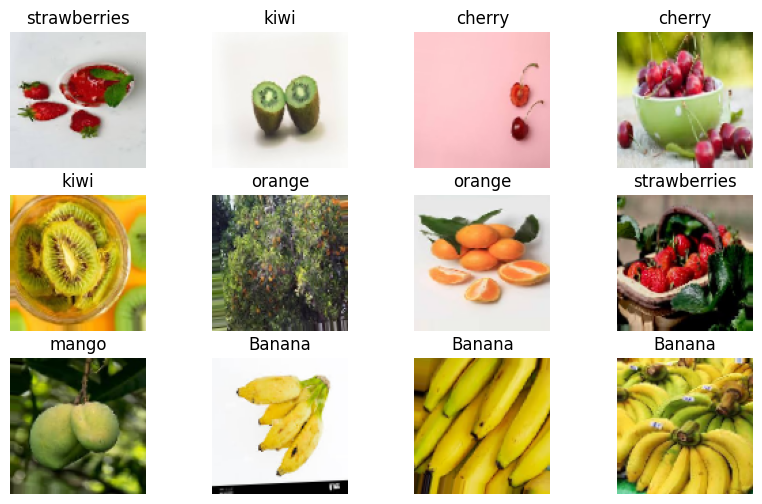

In [4]:
# 👀 Let's look at some fruit pictures before we teach the computer

# We take one group (batch) of images and labels
images, labels = next(train_data)

# Show 6 pictures
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])  # get number for label
    for name, index in train_data.class_indices.items():
        if index == label_index:
            plt.title(name)
    plt.axis('off')
plt.show()


In [5]:
# 🧠 This is our brain. It looks at images, finds patterns, and learns to tell fruits apart.

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),  # Looks at small parts of image
    MaxPooling2D(2, 2),# Shrinks the image to keep only important parts

    Conv2D(64, (3, 3), activation='relu'),  # Looks deeper
    MaxPooling2D(2, 2),

    Flatten(),  # Makes the image flat so the computer can think in numbers
    Dense(128, activation='relu'),  # Thinks with 128 neurons
    Dropout(0.5),  # Turns off some neurons randomly to make learning better
    Dense(train_data.num_classes, activation='softmax')  # Final decision layer: apple, banana, orange, etc.
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# 🧠 Load MobileNetV2, a pre-trained brain, but remove its top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
base_model.trainable = False  # 🧊 Freeze it — we’ll just add our own top

# 🧠 Add custom layers (our own fruit recognizer on top of the smart brain)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# ✅ Final model with base + new head
model = Model(inputs=base_model.input, outputs=predictions)

# ⚙️ Tell the model how to learn (slowly, carefully)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/tmp/ipython-input-6-1715929501.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - accuracy: 0.5622 - loss: 1.3153 - val_accuracy: 0.5200 - val_loss: 1.6959
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.7131 - loss: 0.8724 - val_accuracy: 0.5571 - val_loss: 1.7588
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 240ms/step - accuracy: 0.7745 - loss: 0.7155 - val_accuracy: 0.5756 - val_loss: 1.8048
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 239ms/step - accuracy: 0.7981 - loss: 0.6112 - val_accuracy: 0.5873 - val_loss: 1.8593
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 239ms/step - accuracy: 0.8142 - loss: 0.5620 - val_accuracy: 0.5941 - val_loss: 1.9215
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.8614 - loss: 0.4762 - val_accuracy: 0.5971 - val_loss: 1.9809
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.8546 - loss: 0.4446 - val_accuracy: 0.5971 - val_loss: 2.0105
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 240ms/step - accuracy: 0.8823 - loss: 0.3831 - val_accura

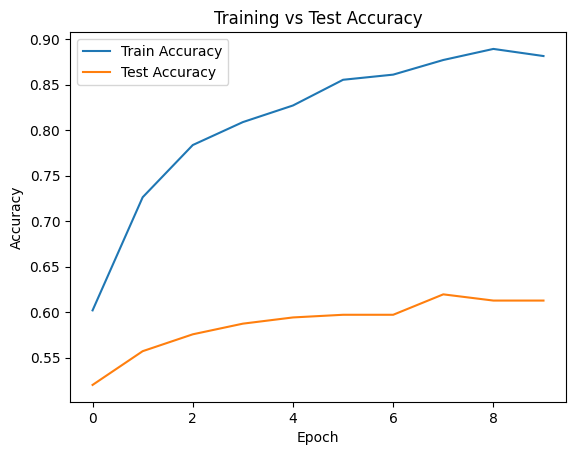

In [8]:
# 🎓 Train the model for 10 epochs
history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

# 📊 Plot how well it did (Train vs Test Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.show()


In [ ]:
# 🎲 Pick some test images and ask the model what fruit it sees

test_images, test_labels = next(test_data)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(test_images[i])
    prediction = model.predict(np.expand_dims(test_images[i], axis=0))
    predicted_index = np.argmax(prediction)
    true_index = np.argmax(test_labels[i])

    predicted_label = list(train_data.class_indices.keys())[predicted_index]
    true_label = list(train_data.class_indices.keys())[true_index]

    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
